In [1]:
import pandas as pd
import numpy as np

In [2]:
# Para descargar los datos
df = pd.read_csv("vid18_180219.dat",delimiter=',')

In [3]:
# Selecciono las columnas de interés
df = df.filter(['TIMESTAMP','AirTC_Avg'],axis=1)
df.head()

,TIMESTAMP,AirTC_Avg
0,2018-05-11 20:10:00,23.50
1,2018-05-11 20:20:00,22.96
2,2018-05-11 20:30:00,22.73
3,2018-05-11 20:40:00,22.40
4,2018-05-11 20:50:00,22.46


In [4]:
# Aquí hago que TIMESTAMP se presente en formato de fecha
# Además, creo las columnas de año, mes, día y hora

df['TIMESTAMP'] = pd.to_datetime(df.apply(lambda x: x['TIMESTAMP'],1), dayfirst=True)
df['Año']=df['TIMESTAMP'].dt.year
df['Mes']=df['TIMESTAMP'].dt.month
df['Dia']=df['TIMESTAMP'].dt.day
df['Hora']=df['TIMESTAMP'].dt.hour 

In [5]:
df['TempProm'] = df['AirTC_Avg']

In [6]:
# Para tomar los datos desde el primero de Noviembre del 2018
df = df[(df['TIMESTAMP'] >= "2018-11-1")]
df= df.reset_index(drop=True)
df.head()

,TIMESTAMP,AirTC_Avg,Año,Mes,Dia,Hora,TempProm
0,2018-11-01 00:00:00,9.13,2018,11,1,0,9.13
1,2018-11-01 00:10:00,8.89,2018,11,1,0,8.89
2,2018-11-01 00:20:00,8.66,2018,11,1,0,8.66
3,2018-11-01 00:30:00,8.52,2018,11,1,0,8.52
4,2018-11-01 00:40:00,8.47,2018,11,1,0,8.47


In [7]:
# Aquí agrego una columna duplicada de AirTC_Avg y la elimino junto con TIMESTAMP
df['TempProm'] = df['AirTC_Avg']
df=df.drop(['TIMESTAMP','AirTC_Avg'],1)
df.head()

,Año,Mes,Dia,Hora,TempProm
0,2018,11,1,0,9.13
1,2018,11,1,0,8.89
2,2018,11,1,0,8.66
3,2018,11,1,0,8.52
4,2018,11,1,0,8.47


In [10]:
df["TMAX"] = np.round(df.groupby(["Año","Mes","Dia"])["TempProm"].transform("max"),decimals=1)
df["TMIN"] = np.round(df.groupby(["Año","Mes","Dia"])["TempProm"].transform("min"),decimals=1)

In [11]:
# Se necesitan quitar los años repetidos por hora, entonces se utiliza
df = df.drop_duplicates(subset=["Año","Mes","Dia","Hora"])
df=df.reset_index(drop=True)
df.head(10)

,Año,Mes,Dia,Hora,TempProm,TMAX,TMIN
0,2018,11,1,0,9.130,29.6,6.1
1,2018,11,1,1,8.560,29.6,6.1
2,2018,11,1,2,8.830,29.6,6.1
3,2018,11,1,3,9.130,29.6,6.1
4,2018,11,1,4,7.924,29.6,6.1
5,2018,11,1,5,7.261,29.6,6.1
6,2018,11,1,6,7.723,29.6,6.1
7,2018,11,1,7,6.125,29.6,6.1
8,2018,11,1,8,12.430,29.6,6.1
9,2018,11,1,9,18.080,29.6,6.1


In [12]:
# Utilizando el modelo Utah de Richardson
URichardson = []
for i in range(0, len(df)):
    temp = df.TempProm[i]
    if (temp <= 1.4):
        temp = 0
        URichardson.append(temp)
    if (1.4 < temp <= 2.4):
        temp = 0.5
        URichardson.append(temp)
    if (2.4 < temp and temp <= 9.1):
        temp = 1.0
        URichardson.append(temp)
    if (9.1 < temp and temp <= 12.4):
        temp = 0.5
        URichardson.append(temp)
    if (12.4 < temp and temp <= 15.9):
        temp = 0
        URichardson.append(temp)
    if (15.9 < temp and temp <= 18.0):
        temp = -0.5
        URichardson.append(temp)
    if (18.0 < temp):
        temp = -1.0
        URichardson.append(temp)

In [13]:
# Utilizando el modelo de INIFAP-CECH
# Donde HF = El número de horas frío por día (0 < T <= 10ºC)
# HFE = El número de horas frío efectivas por día ( HFE= HF - número de horas con T >= 25ºC)
# Primero se tienen que crear los arreglos necesarios

AHF = []
for i in range(0,len(df)):
    thf = df['TempProm'][i]
    if(0 < thf and thf <= 10):
        AHF.append(1)
    else:
        AHF.append(0)
AHC = []
for i in range(0,len(df)):
    thc = df['TempProm'][i]
    if (thc >= 25):
        AHC.append(1)
    else:
        AHC.append(0)

In [19]:
# Agregamos los valores a nuestra tabla del df
df['Modelo UR']=URichardson
df['aHF']=AHF
df['aHC']=AHC
df.head()

,Año,Mes,Dia,Hora,TempProm,TMAX,TMIN,Modelo UR,HF,HC,aHF,aHC
0,2018,11,1,0,9.130,29.6,6.1,0.5,1,0,1,0
1,2018,11,1,1,8.560,29.6,6.1,1.0,1,0,1,0
2,2018,11,1,2,8.830,29.6,6.1,1.0,1,0,1,0
3,2018,11,1,3,9.130,29.6,6.1,0.5,1,0,1,0
4,2018,11,1,4,7.924,29.6,6.1,1.0,1,0,1,0


In [27]:
# Para contar cuantos valores se obtienen por día sobre
# modelo UR, HF y HC
df["UF24"] = df.groupby(["Año","Mes","Dia"])["Modelo UR"].transform("sum")
df["HF"] = df.groupby(["Año","Mes","Dia"])["aHF"].transform("sum")
df["HC"] = df.groupby(["Año","Mes","Dia"])["aHC"].transform("sum")

df = df.drop(["aHF",'aHC','Modelo UR'], 1)
df.head()

,Año,Mes,Dia,Hora,TempProm,TMAX,TMIN,HF,HC,UF24
0,2018,11,1,0,9.130,29.6,6.1,8,5,-2.5
1,2018,11,1,1,8.560,29.6,6.1,8,5,-2.5
2,2018,11,1,2,8.830,29.6,6.1,8,5,-2.5
3,2018,11,1,3,9.130,29.6,6.1,8,5,-2.5
4,2018,11,1,4,7.924,29.6,6.1,8,5,-2.5


In [28]:
# Realizamos de nuevo los datos repetidos por hora
df = df.drop_duplicates(subset=["Año","Mes","Dia"])
df=df.reset_index(drop=True)
df.head()

,Año,Mes,Dia,Hora,TempProm,TMAX,TMIN,HF,HC,UF24
0,2018,11,1,0,9.13,29.6,6.1,8,5,-2.5
1,2018,11,2,0,10.79,31.4,10.0,0,7,-9.5
2,2018,11,3,0,12.85,30.5,10.2,0,8,-8.5
3,2018,11,4,0,13.14,31.4,11.2,0,8,-11.0
4,2018,11,5,0,14.41,31.2,11.1,0,7,-8.5


In [29]:
# Necesitamos el valor acumulado de UF24 y;
# HFE = El número de horas frío efectivas por día ( HFE= HF - número de horas con T >= 25ºC)
df['HFE']=df.HF-df.HC
df.head()

,Año,Mes,Dia,Hora,TempProm,TMAX,TMIN,HF,HC,UF24,HFE
0,2018,11,1,0,9.13,29.6,6.1,8,5,-2.5,3
1,2018,11,2,0,10.79,31.4,10.0,0,7,-9.5,-7
2,2018,11,3,0,12.85,30.5,10.2,0,8,-8.5,-8
3,2018,11,4,0,13.14,31.4,11.2,0,8,-11.0,-8
4,2018,11,5,0,14.41,31.2,11.1,0,7,-8.5,-7


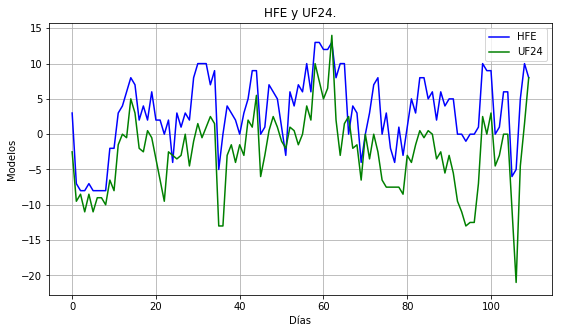

In [45]:
# Graficando ambos modelos
import matplotlib.pyplot as plt

y1 = [df['HFE'][i] for i in range(0,len(df))]
y2 = [df['UF24'][i] for i in range(0,len(df))]


plt.figure(figsize=(9,5))
plt.plot(y1, label = "HFE", color = 'Blue')   
plt.plot(y2, label = "UF24", color = 'Green')   
plt.xlabel("Días")   
plt.ylabel("Modelos")  
plt.legend()
plt.grid()
plt.title('HFE y UF24.')
plt.show()

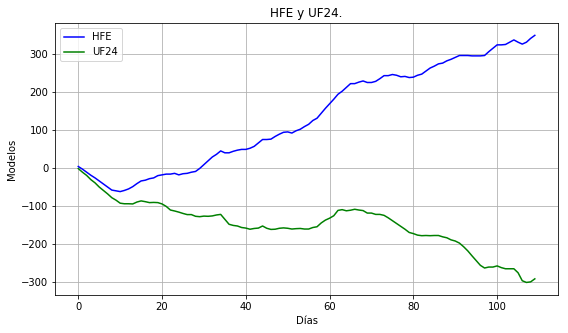

In [46]:
# Graficando los datos de manera acumulada

y1 = df['HFE'].cumsum()
y2 = df['UF24'].cumsum()

plt.figure(figsize=(9,5))
plt.plot(y1, label = "HFE", color = 'Blue')   
plt.plot(y2, label = "UF24", color = 'Green')   
plt.xlabel("Días")   
plt.ylabel("Modelos")  
plt.legend()
plt.grid()
plt.title('Acumulados de HFE y UF24.')
plt.show()